# SST Reconstruction - visual comparison with L4


In this notebook we make a visual comparison between the reconstruction generated by our model and L4.


In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import gdown

loading the residual dataset

In [2]:
#!gdown 1YGAiHCOV8Lv0VVLEFllgrQGyLSz1PQeo #baseline
!gdown 1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r #new climatology

Downloading...
From (original): https://drive.google.com/uc?id=1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r
From (redirected): https://drive.google.com/uc?id=1KJdhGzDx-zKZzMIQv4PzWdk8DPa2w--r&confirm=t&uuid=7ade3cea-577a-4b82-89af-259353660aed
To: /content/l3s_climatology.npy
100% 192M/192M [00:04<00:00, 43.0MB/s]


In [3]:
!gdown 1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh #date

Downloading...
From: https://drive.google.com/uc?id=1CckeQ7Nre4UpITPgWYXI-HF_Le8MtFMh
To: /content/time_l3s.npy
100% 62.9k/62.9k [00:00<00:00, 107MB/s]


In [4]:
#!gdown 1WFD1bHwT4sVPQ6qR5NWHQtdxLUhkkEwB #residual
!gdown 1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H #this should be the file

Downloading...
From (original): https://drive.google.com/uc?id=1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H
From (redirected): https://drive.google.com/uc?id=1p4xMHjU8RvWOKbScxFuSkV--y2hDvy_H&confirm=t&uuid=f89471a1-b79e-49a2-b5a5-d1093ba15c72
To: /content/l3s_residual_n.npy
100% 4.12G/4.12G [01:09<00:00, 59.2MB/s]


In [5]:
!gdown 15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3 #italy mask

Downloading...
From: https://drive.google.com/uc?id=15qwLkJA8CpseRcMgFmms4JM5Wz13AXN3
To: /content/italy_mask.npy
100% 65.7k/65.7k [00:00<00:00, 91.5MB/s]


We also load the weights of our model

In [6]:
#!gdown 1OaeqNJnyxiza62fxsLbTZuC_E9abOQ5w #weights for residual model 256x256 2 previous days
#!gdown 1YNZS_dtCkYXowvdNpU7c4XmK6GtZh6Ri # weights for residual 4 days
#!gdown 14f8DmFrrPN--lQMPTX14eRrNuOTtYoIQ # weights for residual trained on l3s, 2 previous days
!gdown 1S_MC99mnS0qeschEmCabVT-mAUnN2UH5 # weights for residual trained on l3s, 4 previous days

Downloading...
From: https://drive.google.com/uc?id=1S_MC99mnS0qeschEmCabVT-mAUnN2UH5
To: /content/unet256_4days_best.h5
100% 17.2M/17.2M [00:00<00:00, 32.4MB/s]


Let us inspect and visualize data.

In [8]:
#save a local copy of residual_n to avoid problem with gdown
#from google.colab import drive
#.mount('/content/drive')

In [7]:
#residual_n = np.load('/content/drive/My Drive/mediterranean_sst/l3s_residual_n.npy')
residual_n = np.load('/content/l3s_residual_n.npy')

italy_mask = np.load('/content/italy_mask.npy')
land_sea_mask = italy_mask
total_sea = np.sum(italy_mask)

baseline = np.load('/content/l3s_climatology.npy')
#date_n = np.load('/content/time_L3S_day.npy')
date_n = np.load('/content/time_l3s.npy')

In [8]:
print(residual_n.shape)
print(baseline.shape)
print(date_n.shape)
#7851

(7851, 256, 256)
(366, 256, 256)
(7851,)


In [9]:
print(date_n.shape)
date_series_n = pd.to_datetime(date_n, unit='D', origin=pd.Timestamp('1981-01-01'))
day_of_year_n = date_series_n.dayofyear

x_train_n = residual_n[0:5844] # from 2002-07-04 to 2018-07-04
x_val_n = residual_n[5844:6940] # from 2018-07-04 to 2021-07-04
x_test_n = residual_n[6940:] # from 2021-07-04 to 2023-12-31

dates_train_n = date_n[0:5844]
dates_val_n = date_n[5844:6940]
dates_test_n = date_n[6940:]

(7851,)


In [10]:
print(date_series_n[6940])
print(day_of_year_n[6940])

2021-07-04 00:00:00
185


**Normalization**

In [11]:
print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

x_train_std = np.nanstd(x_train_n)
print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

x_train_std = np.nanstd(x_train_n)
x_train_mean = np.nanmean(x_train_n)

print(f"min train residual temperature: {np.nanmin(x_train_n)}")
print(f"max train residual temperature: {np.nanmax(x_train_n)}")
print(f"mean train residual temperature: {np.nanmean(x_train_n)}")
print(f"std train residual temperature: {np.nanstd(x_train_n)}\n")
print(f"std train residual temperature: {np.nanstd(x_train_n)}\n")


(5844, 256, 256)
(1096, 256, 256)
(911, 256, 256)
(5844, 256, 256)
(1096, 256, 256)
(911, 256, 256)
min train residual temperature: -6.4192758185860725
max train residual temperature: 6.882060306721787
mean train residual temperature: -0.10370441977492897
std train residual temperature: 1.0253486394445877

std train residual temperature: 1.0253486394445877



In [12]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n  = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

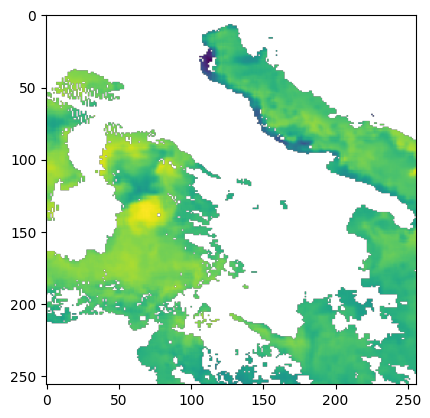

In [13]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

**Land-sea mask**

We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

sea percentage =  0.5947418212890625


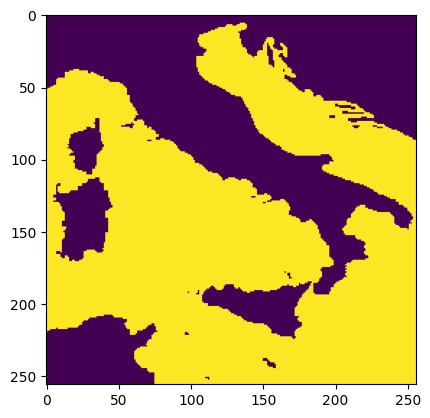

In [14]:
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(256*256))

**Statistical baseline (climatology)**

In [15]:
#baseline = np.load('/content/l3s_baseline_n.npy')
baseline_nan = np.where(land_sea_mask,baseline,np.nan)

In [16]:
print(f"min baseline temperature: {np.nanmin(baseline_nan)}")
print(f"max baseline temperature: {np.nanmax(baseline_nan)}")

min baseline temperature: 7.4271409509820066
max baseline temperature: 27.903212104509006


day 296


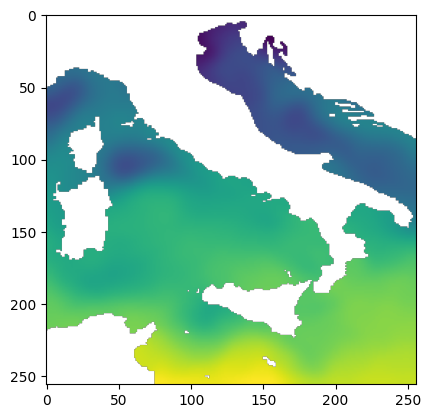

In [17]:
i = np.random.randint(0, baseline.shape[0])
print(f"day {i}")
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

**L4 data (test period)**

In [18]:
!gdown 1iLFCFcs3wR83uuY87ewrc_UTaTKXRuoK

Downloading...
From (original): https://drive.google.com/uc?id=1iLFCFcs3wR83uuY87ewrc_UTaTKXRuoK
From (redirected): https://drive.google.com/uc?id=1iLFCFcs3wR83uuY87ewrc_UTaTKXRuoK&confirm=t&uuid=f9772146-5ffe-4322-ab70-5bcc4cd3edb2
To: /content/l4_sst.npy
100% 478M/478M [00:07<00:00, 63.3MB/s]


Check shapes

In [19]:
#l4 = np.load('/content/drive/My Drive/mediterranean_sst/l4_sst.npy')
l4 = np.load('/content/l4_sst.npy')
print(l4.shape)
print(x_test_n.shape)

(911, 256, 256)
(911, 256, 256)


In [20]:
l4_sst = l4 - 273.15  #convert kelvin to celsius

Let us inspect some L4 data

day 2022-06-16 00:00:00
23.056216227801542
29.5763700270071


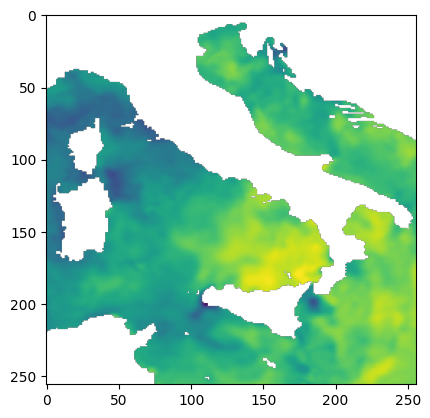

In [21]:
i = np.random.randint(0, l4_sst.shape[0])
print(f"day {date_series_n[i+6922]}")
plt.imshow(l4_sst[i])
print(np.nanmin(l4_sst[i]))
print(np.nanmax(l4_sst[i]))

# GENERATOR

We define a simple "true" data generator without additional clouds for visual comparion with L4.

In [30]:
previous_days = 4
n_channels = 3 + 2*previous_days
isize = 256

def generator_true(batch_size, dataset, date, start_day = None):
    while True:
        batch_x = np.zeros((batch_size, isize, isize, n_channels))
        days = np.zeros(batch_size).astype(int)

        for b in range(batch_size):
            if start_day is not None:
                i = start_day
            else:
              i = np.random.randint(previous_days, dataset.shape[0])    # Start from previous_days to have a sufficient number of them
            days[b] = i

            for j in range(previous_days):
                batch_x[b, ..., j*2] = np.nan_to_num(dataset[i], nan=0)
                batch_x[b, ..., j*2+1] = ~np.isnan(dataset[i])

            batch_x[b, ..., n_channels-1] = italy_mask                 #land-sea mask

        yield batch_x, days

In [32]:
import matplotlib as mpl
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

In [33]:
import matplotlib.pyplot as plt

def plot_elements_discrete(images, titles, dim=12, name="test.png"):
  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = int(np.nanmin(np.array(images)))
  maxi = int(np.nanmax(np.array(images)))
  # define the bins and normalize
  bounds = np.linspace(mini, maxi, 2*(maxi-mini)+1)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  print(mini,maxi)

  fig,axs = plt.subplots(rows, cols,figsize=(dim, dim*num_of_images*1.3))
  for i in range(num_of_images):
    print(f"image {i}; {np.nanmin(images[i])}, {np.nanmax(images[i])}")
    #plt.imshow(images[i],vmin=mini,vmax=maxi,cmap=cmap,norm=norm)
    im = axs[i].imshow(images[i],cmap=cmap,norm=norm)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #plt.axis('off')
    axs[i].set_title(titles[i])
  fig.colorbar(im,ax=axs,shrink=0.06)
  plt.show()
  #plt.savefig(f'images/'+name)

# Unet


In [34]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Conv2DTranspose, Concatenate, concatenate, AveragePooling2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def ResidualBlock(depth):
    def apply(x):
        input_depth = x.shape[3]    # Get the number of channels from the channels dimension
        if input_depth == depth:    # It's already the desired channel number
            residual = x
        else:                       # Adjust the number of channels with a 1x1 convolution
            residual = Conv2D(depth, kernel_size=1)(x)

        x = BatchNormalization(center=False, scale=False)(x)
        x = Conv2D(depth, kernel_size=3, padding="same", activation='swish')(x)
        x = Conv2D(depth, kernel_size=3, padding="same")(x)
        x = Add()([x, residual])
        return x

    return apply


def DownBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(depth)(x)
            skips.append(x)
        x = AveragePooling2D(pool_size=2)(x)    #downsampling
        return x

    return apply


def UpBlock(depth, block_depth):
    def apply(x):
        x, skips = x
        x = UpSampling2D(size=2, interpolation="bilinear")(x)   #upsampling
        for _ in range(block_depth):
            x = Concatenate()([x, skips.pop()])
            x = ResidualBlock(depth)(x)
        return x

    return apply


def get_Unet(image_size, depths, block_depth):
    input_images = Input(shape=image_size)  #input layer

    x = Conv2D(depths[0], kernel_size=1)(input_images)  #reduce the number of channels

    skips = []  #store the skip connections

    for depth in depths[:-1]:   #downsampling layers
        x = DownBlock(depth, block_depth)([x, skips])

    for _ in range(block_depth):    #middle layer
        x = ResidualBlock(depths[-1])(x)

    for depth in reversed(depths[:-1]):   #upsampling layers
        x = UpBlock(depth, block_depth)([x, skips])

    x = Conv2D(1, kernel_size=1, kernel_initializer="zeros", name = "output_noise")(x)  #no activation function

    return Model(input_images, outputs=x, name="UNetInpainter")


# Custom loss function (weighted MSE)
def custom_loss(y_true, y_pred):
    mask = y_true[..., 2]  # Using the diff mask (check!!!)
    diff = tf.square(y_pred[..., 0] - y_true[..., 0])
    weighted_diff = diff * mask
    return tf.reduce_mean(weighted_diff)

In [35]:
# Create the U-Net model
input_shape = (256, 256, n_channels)  # Input shape including the mask (4 channels)
depths = [32, 64, 128, 256]           # channels at downsampling
#depths = [64, 128, 256, 512]         #
block_depth = 2                       #
model_unet = get_Unet(input_shape, depths, block_depth)

# Compile the model with custom loss and Adam optimizer
adam= Adam(learning_rate=1e-3, weight_decay=1e-4)
model_unet.compile(optimizer=adam,
                   loss=custom_loss,
                   metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

# Summary of the model
# model_unet.summary()

In [36]:
#load weights
model_unet.load_weights('/content/unet256_4days_best.h5')  #training with l3s, 4 previous days
#model_unet.load_weights('/content/unet256_marzo2025_2days.h5')
#model_unet.load_weights('/content/unet256residual4d.h5')

# Visual Comparison with L4

For visual comparison with L4 we generate reconstructions from true data, without additional clouds.

In [37]:
real_test_gen=generator_true(16, x_test_n, dates_test_n)

The code is meant to select and visualize interesting samples from a minibatch of data. "Interesting" means that there is a large cloud coverage in the input, together with a a sensible difference between the reconstructions of our model and that of L4.

[822 357 722 876 309 293 500 679  64 443  65 773 792 526 850 365]
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
(16, 256, 256)
(16, 256, 256)
22376.174678095813
visibility: [0.83875106 0.82222849 0.79182595 0.11196347 0.66500757 0.54539857
 0.53103112 0.19072787 0.86379147 0.79513559 0.62711343 0.96795546
 0.72499166 0.30215255 0.46499217 0.89442492]
4
14 20
image 0; 14.75936577796907, 19.686059094675265
image 1; 14.758337141197192, 19.56814113261368
image 2; 14.501733522498455, 20.026545480141067


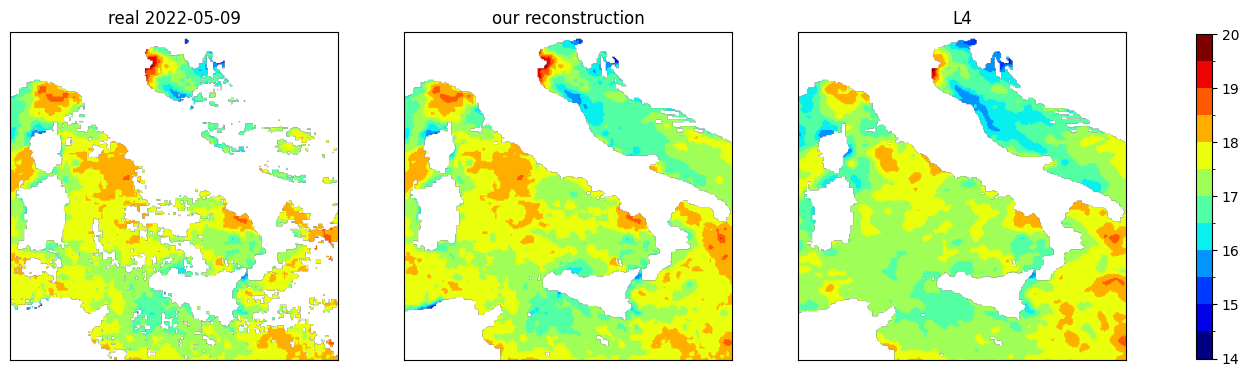

In [38]:
batch_x, days = next(real_test_gen)
#days[0]=105
days_of_year = day_of_year_n[days+6940]
print(days)
predictions = model_unet.predict(batch_x)[...,0]
prediction_denorm = predictions* x_train_std + x_train_mean + baseline[days_of_year]
prediction_denorm = np.where(land_sea_mask,prediction_denorm,np.nan)
real_denorm = batch_x[...,0] * x_train_std + x_train_mean + baseline[days_of_year]
real_denorm = np.where(batch_x[...,1],real_denorm,np.nan)
print(prediction_denorm.shape)
print(real_denorm.shape)
# trying to select interesting data within the minibatch
l4_sst_0 = l4_sst[days]
l4_sst_0 = np.where(land_sea_mask,l4_sst_0,np.nan)
l4_error = (l4_sst_0 - real_denorm)**2
prediction_error =  (prediction_denorm - real_denorm)**2
visibility = np.nansum(batch_x[...,1],axis=(1,2))/total_sea
distance = np.nansum(l4_error - prediction_error,axis=(1,2))
print(np.sum(distance))
print(f"visibility: {visibility}")
i = np.argmax(distance/visibility)
print(i)
date_0 = str(date_series_n[days[i]+6940].date())
plot_elements_discrete([real_denorm[i], prediction_denorm[i], l4_sst_0[i]], ['real '+date_0, 'our reconstruction', 'L4',], dim=18)

Below we select exemples with the maximum cloud coverage

[744  94 576  20 655 465 519 427 660 881 744 606  65 628 885 268]
Index([199, 279, 31, 205, 110, 285, 339, 247, 115, 336, 199, 61, 250, 83, 340,
       88],
      dtype='int32')
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
8 15
image 0; 8.805951444608452, 15.699401638079625
image 1; 8.66754587236805, 15.663994014159146
image 2; 9.923399080029583, 15.54896752431415


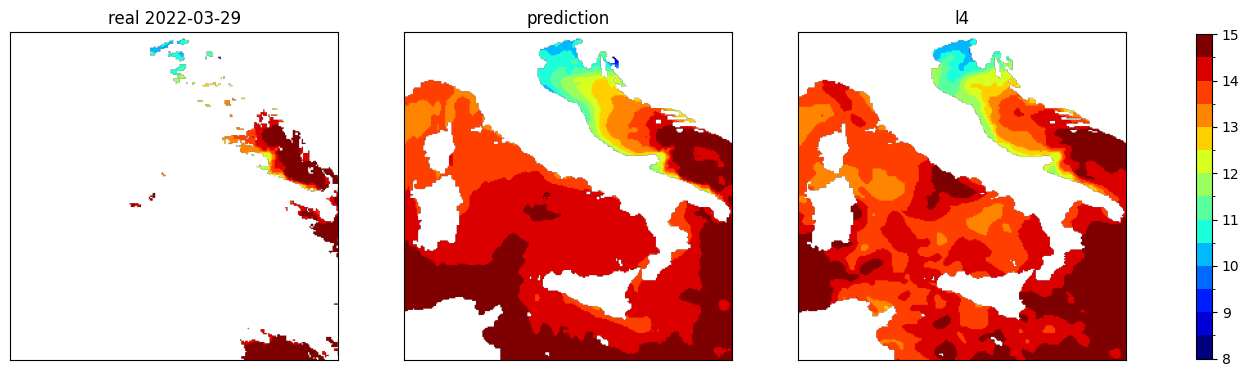

In [39]:
batch_x, days = next(real_test_gen)
print(days)
#days[0]=105
days_of_year = day_of_year_n[days+6940]
print(days_of_year)
i = np.argmin(np.nansum(batch_x[...,1],axis=(1,2))) #max clouds in
#i = 0
date_0 = str(date_series_n[days[i]+6940].date())
predictions = model_unet.predict(batch_x[i:i+1])
prediction_denorm = predictions[0,...,0] * x_train_std + x_train_mean + baseline[days_of_year[i]]
prediction_denorm = np.where(land_sea_mask,prediction_denorm,np.nan)
real_denorm = batch_x[i,...,0] * x_train_std + x_train_mean + baseline[days_of_year[i]]
real_denorm = np.where(batch_x[i,...,1],real_denorm,np.nan)
l4_sst_0 = l4_sst[days[i]]
l4_sst_0 = np.where(land_sea_mask,l4_sst_0,np.nan)

plot_elements_discrete([real_denorm, prediction_denorm, l4_sst_0], ['real '+date_0, 'prediction', 'l4',], dim=18)

# Animation

The following code allows to create animantions. We do an animation for the SST prediction realtive to the year 2022.

In [40]:
print(day_of_year_n[181+6940])

1


In [42]:
year_2022, days = next(generator_true(365, x_test_n, dates_test_n, start_day = 181))
print(days[0])
print(day_of_year_n[days[0]])

181
1


In [43]:
predictions_2022 = model_unet.predict(year_2022)
print(predictions_2022.shape)
predictions_2022 = predictions_2022[0,...,0] * x_train_std + x_train_mean + baseline[:365]
predictions_2022 = np.where(land_sea_mask,predictions_2022,np.nan)

12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
(365, 256, 256, 1)


In [44]:
print(predictions_2022.shape)
np.save('/content/predictions_2022.npy', predictions_2022)

(365, 256, 256)


In [45]:
import matplotlib.animation as animation

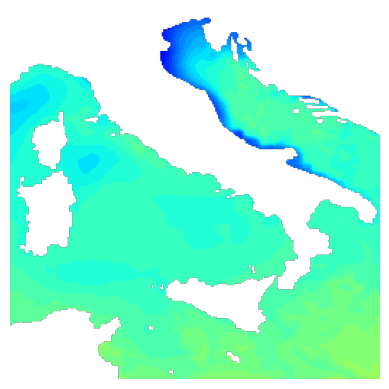

done


In [47]:
mini = int(np.nanmin(predictions_2022))
maxi = int(np.nanmax(predictions_2022))

bounds = np.linspace(mini, maxi, 2*(maxi-mini)+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
ax.axis("off")  # Hide axis
plt.tight_layout
img = ax.imshow(predictions_2022[0], cmap=cmap, norm=norm)  # Initialize with first frame

# Animation update function
def update(i):
    img.set_array(predictions_2022[i])  # Update image data
    return [img]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=predictions_2022.shape[0], interval=100)

# Save animation (optional)
ani.save("animation.mp4", writer="ffmpeg", fps=10)  # Adjust FPS as needed

# Display animation
plt.show()
print("done")